In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from PIL import Image
from matplotlib.image import imread

In [ ]:
# DATA_900 folder contains 900 images with .ppm extension

data_path = '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900'

In [ ]:
# Split the 43 classes to 4 categories

prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]
danger = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
mandatory = [33, 34, 35, 36, 37, 38, 39, 40]
other = [6, 12, 13, 14, 17, 32, 41, 42]

In [ ]:
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
# Load the gt.txt text file that contains the bounding boxes coordinates and class labels for all objects in all 900 images.
# The text file has 6 columns as follows => ImgNo.ppm  ;   Left_Column;   Top_Row;   Right_Column;   Bottom_Row;   ClassID
# Each line in the text file indicates to a single object.

data_text_file = pd.read_csv(data_path + '/gt.txt',
                             names=['Image_name',
                                    'X_min(Left_Column)'  ,    # Left_Column
                                    'Y_min(Top_Row)'      ,    # Top_Row
                                    'X_max(Right_Column)' ,    # Right_Column
                                    'Y_max(Bottom_Row)'   ,    # Bottom_Row
                                    'ClassID']            ,
                             sep=';')


In [ ]:
print("Number of object in all images is: {}".format(len(data_text_file)))

Number of object in all images is: 1213


In [ ]:
# Printing the first 5 rows from the file

data_text_file.head()

,Image_name,X_min(Left_Column),Y_min(Top_Row),X_max(Right_Column),Y_max(Bottom_Row),ClassID
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


In [ ]:
# Printing the last 5 rows from the file

data_text_file.tail()

,Image_name,X_min(Left_Column),Y_min(Top_Row),X_max(Right_Column),Y_max(Bottom_Row),ClassID
1208,00896.ppm,808,412,846,450,15
1209,00897.ppm,804,526,828,550,42
1210,00898.ppm,323,504,355,536,4
1211,00898.ppm,817,510,849,542,4
1212,00899.ppm,864,484,921,534,24


In [ ]:
# Taking a copy from the text file to change it to YOLO format

data_file = data_text_file.copy()

**From here we will convert the text file from its structure to the structure of YOLO format that is requered to train YOLO model on Darknet.**

This format contains one text file per image (containing the annotations and a numeric representation of the label)
and a labelmap which maps the numeric IDs to human readable strings. The annotations are normalized to lie within 
the range [0, 1] which makes them easier to work with even after scaling or stretching images.


we will convert the coordinates of the bounding boxes from its current format to YOLO format, 

the current format is [x_min, Y_min, X_max, Y_max]

In yolo, a bounding box is represented by four values [x_center, y_center, width, height].
as follows.
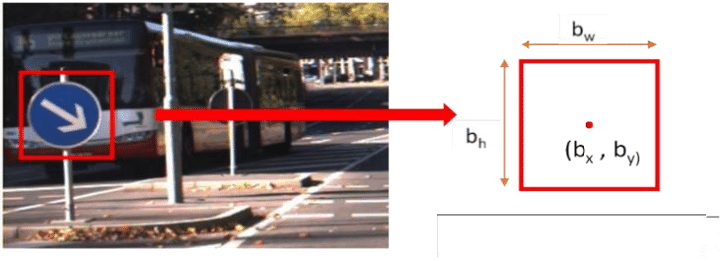

In [ ]:
# We make here new columns for bounding boxes of YOLO format and the new CategoryID 

data_file['Center_X'] = (data_file['X_min(Left_Column)'] + data_file['X_max(Right_Column)']) / 2
data_file['Center_Y'] = (data_file['Y_min(Top_Row)'] + data_file['Y_max(Bottom_Row)']) / 2

data_file['Width'] = data_file['X_max(Right_Column)'] - data_file['X_min(Left_Column)']
data_file['Height'] = data_file['Y_max(Bottom_Row)'] - data_file['Y_min(Top_Row)']

data_file['CategoryID'] = ''
data_file.loc[data_file['ClassID'].isin(prohibitory), 'CategoryID'] = 0
data_file.loc[data_file['ClassID'].isin(danger), 'CategoryID'] = 1
data_file.loc[data_file['ClassID'].isin(mandatory), 'CategoryID'] = 2
data_file.loc[data_file['ClassID'].isin(other), 'CategoryID'] = 3

In [ ]:
# Printing the first 5 rows from the new file after adding 

data_file.head()

,Image_name,X_min(Left_Column),Y_min(Top_Row),X_max(Right_Column),Y_max(Bottom_Row),ClassID,Center_X,Center_Y,Width,Height,CategoryID
0,00000.ppm,774,411,815,446,11,794.5,428.5,41,35,1
1,00001.ppm,983,388,1024,432,40,1003.5,410.0,41,44,2
2,00001.ppm,386,494,442,552,38,414.0,523.0,56,58,2
3,00001.ppm,973,335,1031,390,13,1002.0,362.5,58,55,3
4,00002.ppm,892,476,1006,592,39,949.0,534.0,114,116,2


In [ ]:
# Deleting the old format

data_file = data_file.drop(['X_min(Left_Column)', 'Y_min(Top_Row)', 'X_max(Right_Column)', 'Y_max(Bottom_Row)', 'ClassID'], axis=1)

In [ ]:
data_file.head()

,Image_name,Center_X,Center_Y,Width,Height,CategoryID
0,00000.ppm,794.5,428.5,41,35,1
1,00001.ppm,1003.5,410.0,41,44,2
2,00001.ppm,414.0,523.0,56,58,2
3,00001.ppm,1002.0,362.5,58,55,3
4,00002.ppm,949.0,534.0,114,116,2


In [ ]:
second_column = data_file.pop('CategoryID')
data_file.insert(1, 'CategoryID', second_column)
data_file.head()

,Image_name,CategoryID,Center_X,Center_Y,Width,Height
0,00000.ppm,1,794.5,428.5,41,35
1,00001.ppm,2,1003.5,410.0,41,44
2,00001.ppm,2,414.0,523.0,56,58
3,00001.ppm,3,1002.0,362.5,58,55
4,00002.ppm,2,949.0,534.0,114,116


In [ ]:
data_path = '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900'
jpg_with_txt_data_path = '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT'
os.chdir(data_path)
print(os.getcwd())

/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900


In [ ]:
# Using os.walk() is for going through all directories and files from the current directory

for current_directory, directories, files in os.walk('.'):
  for f in files:
    if f.endswith('.ppm'):
      image_ppm = cv2.imread(f)
      height, width = image_ppm.shape[:2]
      image_name = f[:-4]
      sub_data_file = data_file.loc[data_file['Image_name'] == f].copy()
      # The next 4 lines are responsible of normalizing the values of coordinates between 0 and 1
      sub_data_file['Center_X'] = sub_data_file['Center_X'] / width
      sub_data_file['Center_Y'] = sub_data_file['Center_Y'] / height
      sub_data_file['Width'] = sub_data_file['Width'] / width
      sub_data_file['Height'] = sub_data_file['Height'] / height
      result_dataFrame = sub_data_file.loc[:, ['CategoryID',
                                               'Center_X',
                                               'Center_Y',
                                               'Width',
                                               'Height']].copy()
      if result_dataFrame.isnull().values.all():
        continue

      path_to_save = jpg_with_txt_data_path + '/' + image_name + '.txt'
      result_dataFrame.to_csv(path_to_save, header=False, index=False, sep=' ')
      path_to_save = jpg_with_txt_data_path + '/' + image_name + '.jpg'
      cv2.imwrite(path_to_save, image_ppm)


In [ ]:
files = os.listdir(jpg_with_txt_data_path)
lengths = len(files)
print('The total number of images with their txt file {} :'.format(lengths))

The total number of images with their txt file 1482 :


In [ ]:
print(jpg_with_txt_data_path)
os.chdir(jpg_with_txt_data_path)
print(os.getcwd())

/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT
/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT


In [ ]:
# Putting he paths of all images into one list to split the images into train and validation data, and after that making train.txt and test.txt files that requered for the training process

jpg_with_txt_data_path = ''
images_paths_file = []
for current_directory, directories, files in os.walk('.'):
  for f in files:
    if f.endswith('.jpg'):
      images_paths = jpg_with_txt_data_path + '/' + f
      images_paths_file.append(images_paths + '\n')


In [ ]:
print(len(images_paths_file))
random.shuffle(images_paths_file)
images_paths_file[:5]

741


['/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT/00891.jpg\n',
 '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT/00853.jpg\n',
 '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT/00172.jpg\n',
 '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT/00330.jpg\n',
 '/content/gdrive/MyDrive/AV_seminar/Detection/DATA_900/DATA_jpg_with4Classes_TXT/00380.jpg\n']

In [ ]:
test_percentage = 0.15  # The percentage for validation data
images_paths_test = images_paths_file[:int(len(images_paths_file) * test_percentage)]
images_paths_train = images_paths_file[int(len(images_paths_file) * test_percentage):]

print(len(images_paths_train)) # Number of training images
print(len(images_paths_test)) # Number of validation images
print(type(images_paths_test))
print(type(images_paths_test))


630
111
<class 'list'>
<class 'list'>


**Creating the train.txt and test.txt files**

In [ ]:
with open('train.txt', 'w') as train_txt:
  for path in images_paths_train:
    train_txt.write(path)

with open('test.txt', 'w') as test_txt:
  for path in images_paths_test:
    test_txt.write(path)

**Creating the classes_names.names file**

In [ ]:
class_name = open('classes_names.names', 'w')
for name in classes_names:
    class_name.write(name + '\n')
class_name.close()

**Creating the tf_data.data file**

In [ ]:
file_data = open(jpg_with_txt_data_path + '/' + 'tf_data.data', 'w')
file_data.write('classes = 4' + '\n')
file_data.write('train = ' + jpg_with_txt_data_path + '/' + 'train.txt' + '\n')
file_data.write('valid = ' + jpg_with_txt_data_path + '/' + 'test.txt' + '\n')
file_data.write('names = /content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/darknet/data/tf_category.names' + '\n')
file_data.write('backup = ' + '/content/gdrive/MyDrive/AV_seminar/Detection/YOLOv4/training/new')
file_data.close()